# Композиции классификаторов (градиентный бустинг)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

!pip install catboost
!pip install lightgbm

## Библиотеки

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
import numpy as np
from sklearn import tree, base
import itertools
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, BaggingClassifier)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression, load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
import torch

import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

## ComBoost

Рассмотрим следующее ансамблирование ответов:
$$
b(x) = \frac{1}{T}\sum_{t=1}^{T} b_t(x)
$$

Рассмотрим отступ объектов:
$$
M(x) = \Gamma_y\bigr(x\bigr) - \max_{y} \Gamma_y\bigr(x\bigr)
$$

Идея в том, что каждый $b_t$ компенсирует ошибки ансамбля, состоящего из всех предыдущих моделей:
$$
Q\bigr(b_t, U_t\bigr) = \sum_{x \in U_t}\left[M(x) < 0\right] \to \min_{b_t},
$$
$$
U_t = \left\{x| M_l < M_{t-1}(x) < M_g\right\}.
$$


In [ ]:
class ComBoost(object):
    def __init__(self, base_estimator=None, n_estimators=10):
        self.n_estimators = n_estimators
        self.base_estimator = DecisionTreeClassifier(max_depth=1)
        if base_estimator:
            self.base_estimator = base_estimator
        self.b = [base.clone(self.base_estimator) for _ in range(self.n_estimators)]

    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators,
                'base_estimator': self.base_estimator}

    @staticmethod
    def fix_predict_proba(pred, b, b0):
        new_pred = np.zeros((len(pred), len(b0.classes_)))
        for i, cl in enumerate(b.classes_):
            new_pred[:, cl] = pred[:, i]
        return new_pred

    def fit(self, X, Y, l0=0, l1=100, l2=None, dl=100):
        def margin(pr, y):
            cop = pr.copy()
            cop[y] = -1
            return pr[y] - cop.max()

        if l2 is None:
            l2 = len(X)

        for t, b in enumerate(self.b):
            if t == 0:
                b.fit(X, Y)
                pred = b.predict_proba(X)
                M = np.array([margin(pred[i], Y[i]) for i in range(len(Y))])
            else:
                indexes = sorted(np.arange(0, len(X)), key = lambda i: M[i])
                X_new = X[indexes]
                Y_new = Y[indexes]
                dict_of_param = []
                for k in range(l1, l2, dl):
                    new_item = {'l0': l0,
                                'k': k}

                    local_b = base.clone(self.base_estimator)
                    local_b.fit(X_new[l0:k], Y_new[l0:k])

                    pred = self.fix_predict_proba(local_b.predict_proba(X), local_b, self.b[0])
                    M_new = np.array([margin(pred[i], Y[i]) for i in range(len(Y))])

                    new_item['Q'] = (M+M_new < 0).sum()
                    dict_of_param.append(new_item)

                element = sorted(dict_of_param, key=lambda x: x['Q'])[0]
                b.fit(X_new[element['l0']:element['k']],
                      Y_new[element['l0']:element['k']])

                pred = self.fix_predict_proba(b.predict_proba(X), local_b, self.b[0])
                M = M + np.array([margin(pred[i], Y[i]) for i in range(len(Y))])


    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

    def predict_proba(self, X):
        return np.mean([self.fix_predict_proba(elem.predict_proba(X), elem, self.b[0]) for elem in self.b], axis=0)

### Пример использования

Данный метод позволяет строить ансамли для произвольных базовых функций. Далее приводится пример:
- Решающего дерева
- SVM
- Логистической регресии

In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = DecisionTreeClassifier(max_depth=2)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('SCORE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.704 (0.049)


In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = ComBoost(DecisionTreeClassifier(max_depth=2))

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.81 (0.03)


In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = SVC(probability=True)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.94 (0.02)


In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = ComBoost(SVC(probability=True))

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.95 (0.02)


In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.80 (0.03)


In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = ComBoost(LogisticRegression())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.80 (0.03)


### Выводы
Получаем, что ансамблирование не ухудшает качества на кроссвалидации. В случае простых моделей (дерево с ограниченной глубиной), качество улучшается значительно, а в случае сложны моделей (SVM) качество улучшается не значительно.

## Gradient Boosting

Рассмотрим следующее ансамблирование ответов:
$$
b(x) = \sum_{t=1}^{T} b_t(x)
$$

Рассмотрим среднеквадратичекое отклонение:
$$
L = \sum_{i=1}^{l}\left(b(x_i) - y_i\right)^2
$$

Идея состоит в том, что каждая новая модель пытается аппроксимировать остатки которые оставили прошлые модели:
$$
L_t = \sum_{i=1}^{l}\left(b_t(x_i) - (y_i - \sum_{j=1}^{t}b_j(x_i))\right)^2 \min_{b_t}
$$

In [ ]:
class GradientBoostingRegression(object):
    def __init__(self, base_estimator=None, n_estimators=10):
        self.n_estimators = n_estimators
        self.base_estimator = DecisionTreeRegressor(max_depth=1)
        if base_estimator:
            self.base_estimator = base_estimator

        self.b = [base.clone(self.base_estimator) for _ in range(self.n_estimators)]

    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators,
                'base_estimator': self.base_estimator}

    def score(self, X, Y):
        return ((self.predict(X) - Y)**2).mean()

    def fit(self, X, Y):
        residual = Y.copy()
        for t, b in enumerate(self.b):
            b.fit(X, residual)
            residual = residual - b.predict(X)

    def predict(self, X):
        return np.sum([elem.predict(X) for elem in self.b], axis=0)


### Пример использования

Данный метод позволяет строить ансамли для произвольных базовых функций. Далее приводится пример:
- Решающего дерева
- SVM
- Линейная регресии

In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = DecisionTreeRegressor(max_depth=2)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.37 (0.08)


In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = GradientBoostingRegression(DecisionTreeRegressor(max_depth=2))

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 5392.99 (837.37)


In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = SVR()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.11 (0.01)


In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = GradientBoostingRegression(SVR())

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 5340.38 (1169.58)


In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = SVR(kernel='linear')

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 1.00 (0.00)


In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = GradientBoostingRegression(SVR(kernel='linear'))

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.00 (0.00)


In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = LinearRegression()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 1.00 (0.00)


In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = GradientBoostingRegression(LinearRegression())

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.00 (0.00)


### Вывод

Качество очень сильно зависит от выбранной базовой функции

## XGBoost

Пакет `xgboost` является один из библиотек для построения деревьев на основе градиентного бустинга. В основном все такие библиотеки работают только с решающими деревьями (ансамбли принято строить над деревьями), подробное описания модификации описано в [статье](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf).

- Ускорение заключается в более оптимальном подборе порогов в каждой вершине дерева.
- Модифицировали алгоритм для паралельного обучения деревьев (напомним, что классический бустинг не позволяет выполнять паралельную обработку).
- Специальные инженерные трюки для сбалансированого использования кеша.

Данный framework имеет следующие плюсы:
- Хорошая документация.
- Позволяет легко паралелить вычисления.
- Легко использовать с `sklearn` и `numpy` (но с потерей производительности)

Недостатки:
- Нет поддержки GPU.

In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = xgb.XGBClassifier(objective='binary:logistic', random_state=6)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.88 (0.03)


In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, random_state=6)
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=6)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.93 (0.01)


## LightGBM

Пакет `lightgbm` представлен Microsoft как реализация градиентного бустинга над деревьями. Работа с подробным описаниям введений описана [тут](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf).

Сам метод модифицирует метод XGboost с дополнительной процедурой ресемплинга объектов для ускорения построения деревьев.


Данный фраймворк имеет следующие положительные моменты:
- Хорошая документация.
- Имеется поддержка GPU.
- Имеет поддержку категориальных признаков на основе метода Фишера, который описан [тут](https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features).

Недостатки:
- Сложно использовать с `numpy` и `sklearn` так как требует специфичного формата данных.

In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)

train_data = lgb.Dataset(X, label=y)
param = {'num_leaves': 31,
         'objective': 'multiclass',
         'num_class': 2,
         'metric': ['multi_logloss']}

num_round = 10
bst = lgb.train(param, train_data, num_boost_round=10)

(bst.predict(X).argmax(axis=-1) == y).mean()

0.946

## CatBoost

Пакет `catboost` представлен Яндексом для построения ансамблей моделей на базе решающих деревьев. Подробное описание доступно в [работе](https://papers.nips.cc/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf).

- Основной идеей и посылом для создания CatBoost была разработка метода работы с категориальными признаками (отсюда и названия).
- В классическом машинном обучении принято категориальные признаки кодировать One-Hot векторами. В работе предлагался метод, который выделяет кластеры внутри категориального признака на основе предлагаемых в работе статистик.

Данный framework имеет следующие плюсы:
- Хорошая документация.
- Позволяет легко паралелить вычисления на GPU.
- Легко использовать с `sklearn` и `numpy` (но с потерей производительности).
- Поддержка категориальных признаков (причем продвинутая, в отличии от простых методов Фишера).

Недостатки:
- Во многих задачах показывает себя хуже чем XGboost и LightGBM.
- В статье показано, что данный метод работает лучше чем XGboost и LightGBM, но в реальных кейсах это не так...

In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)

model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True, task_type='CPU')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.75 (0.03)


In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)

model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True, task_type='GPU')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

SCORE: 0.73 (0.04)


### Задание

Загрузить на ваш выбор датасет из sklearn.datasets

Выбрать метрики качества

Обучить любой ансамбль на ваш выбор (лес, CatBoost и пр)

Продемонстрировать метрики. Можно с визуализацией

Точность (Accuracy): 0.965034965034965
Прецизионность (Precision): 0.9666666666666667
Полнота (Recall): 0.9775280898876404
F1-мера: 0.9720670391061452


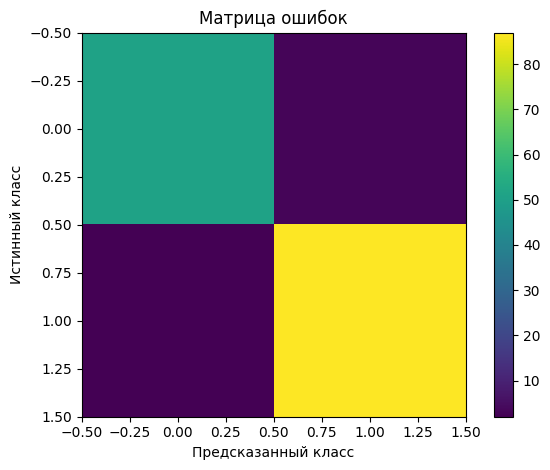

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Точность (Accuracy):", accuracy_score(y_test, y_pred))
print("Прецизионность (Precision):", precision_score(y_test, y_pred))
print("Полнота (Recall):", recall_score(y_test, y_pred))
print("F1-мера:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm)
plt.title("Матрица ошибок")
plt.colorbar()
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()
